In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gwpopulation as gwpop # using the mass model there

In [2]:
import h5py
import pandas as pd
from scipy.interpolate import interp1d, interp2d
from astropy import cosmology, units, constants
from astropy.cosmology import Planck15, FlatLambdaCDM
from tqdm import tqdm
import astropy.units as u


In [3]:
H0Planck = Planck15.H0.value
Om0Planck = Planck15.Om0
speed_of_light = constants.c.to('km/s').value

In [4]:
def infer_required_args_from_function_except_n_args(func, n=1): # Modified from bilby, to get the arguments of posterior
    fullparameters = inspect.getfullargspec(func)
    parameters = fullparameters.args[:len(fullparameters.args) - len(fullparameters.defaults)]
    del parameters[:n]
    return parameters

In [5]:
# Function including dnesities
def E(z,Om0=Om0Planck):
    return np.sqrt(Om0*(1+z)**3 + (1.0-Om0))

# Comoving volume
def dVdz(z, H0=H0Planck):
    cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Om0Planck)
    r_of_z = cosmo.comoving_distance(z).to(u.Mpc).value
    return (speed_of_light / H0*E(z)) * r_of_z**2 

In [6]:
def p_m1(data, alpha, m_max):
    masses = data['mass_1'].values
    mask = masses<m_max
    
    res = np.zeros(len(masses))
    res[mask] =  masses[mask]**(-alpha)
    return res

def p_q(data, beta, m_min):
    mass1 = data['mass_1'].values
    mass_ratios = data['mass_ratio'].values
    
    mask = mass_ratios>(m_min/mass1)
    mask2 = mass_ratios<1
    
    res = np.where(mask & mask2, mass_ratios**(beta), 0)
    return res

def p_z(data, kappa): 
    return (1+data['redshift'])**(kappa-1) * dVdz(data['redshift'])


def total_p(data, alpha, beta, kappa, m_min, m_max):
    return p_m1(data, alpha, m_max)*p_q(data, beta, m_min)*p_z(data, kappa)

In [7]:
# p_m1 = gwpop.models.mass.two_component_primary_mass_ratio

def compute_log_likelihood_per_event(data, Lambda, prior):
    ratio = np.divide(total_p(data, *Lambda), prior, out=np.zeros_like(prior), where=prior!=0)
    ratio[ratio==0] = 1e-15
    return np.log(np.mean(ratio))

def log_likelihood(Lambda, posteriors):
    log_likelihood = 0.
    for posterior in posteriors:
        if "prior" in posterior:
            prior = posterior["prior"]
        else:
            prior = 1
        log_likelihood += compute_log_likelihood_per_event(posterior, Lambda, prior)
    return log_likelihood

In [8]:
parameter_translator = dict(
    mass_1_det="m1_detector_frame_Msun",
    mass_2_det="m2_detector_frame_Msun",
    luminosity_distance="luminosity_distance_Mpc",
    a_1="spin1",
    a_2="spin2",
    cos_tilt_1="costilt1",
    cos_tilt_2="costilt2",
)

posteriors = list()
priors = list()

file_str = "./GWTC-1_sample_release/GW{}_GWTC-1.hdf5"

events = [
    "150914",
    "151012",
    "151226",
    "170104",
    "170608",
    "170729",
    "170809",
    "170814",
    "170818",
    "170823",
]
for event in events:
    _posterior = pd.DataFrame()
    _prior = pd.DataFrame()
    with h5py.File(file_str.format(event)) as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff["IMRPhenomPv2_posterior"][gwtc_key]
            _prior[my_key] = ff["prior"][gwtc_key]
    posteriors.append(_posterior)
    priors.append(_prior)

In [9]:
luminosity_distances = np.linspace(1, 10000, 1000)
redshifts = np.array(
    [
        cosmology.z_at_value(cosmology.Planck15.luminosity_distance, dl * units.Mpc)
        for dl in luminosity_distances
    ]
)
dl_to_z = interp1d(luminosity_distances, redshifts)

luminosity_prior = luminosity_distances**2

dz_ddl = np.gradient(redshifts, luminosity_distances)

redshift_prior = interp1d(redshifts, luminosity_prior / dz_ddl / (1 + redshifts)**2)

In [10]:
for posterior in posteriors:
    posterior["redshift"] = dl_to_z(posterior["luminosity_distance"])
    posterior["mass_1"] = posterior["mass_1_det"] / (1 + posterior["redshift"])
    posterior["mass_2"] = posterior["mass_2_det"] / (1 + posterior["redshift"])
    posterior["mass_ratio"] = posterior["mass_2"] / posterior["mass_1"]
    posterior["prior"] = redshift_prior(posterior["redshift"]) * posterior["mass_1"]

In [11]:
import bilby as bb
from bilby.core.prior import LogUniform, PriorDict, Uniform
from bilby.hyper.model import Model

In [12]:
fast_priors = PriorDict()

# mass
fast_priors["alpha"] = Uniform(minimum=-3, maximum=4, latex_label="$\\alpha$")
fast_priors["beta"] = Uniform(minimum=-4, maximum=12, latex_label="$\\beta$")
fast_priors["kappa"] = Uniform(minimum=5, maximum=14, latex_label="$\\kappa$")
fast_priors["mmin"] = Uniform(minimum=5, maximum=10, latex_label="$m_{\\min}$")
fast_priors["mmax"] = Uniform(minimum=30, maximum=70, latex_label="$m_{\\max}$")
# fast_priors["lam"] = Uniform(minimum=0, maximum=1, latex_label="$\\lambda_{m}$")
# fast_priors["mpp"] = Uniform(minimum=10, maximum=50, latex_label="$\\mu_{m}$")
# fast_priors["sigpp"] = Uniform(minimum=0, maximum=10, latex_label="$\\sigma_{m}$")


In [13]:
# def log_prior(Lambda):
#     alpha, beta, mmin, mmax, lam, mpp, sigpp = Lambda
#     if -2<alpha<4 and -4<beta<12 and 5<mmin<10 and 20<mmax<60 and 0<lam<1 and 10<mpp<50 and 0<sigpp<10:
#         return 0.
#     return -np.inf

def log_prior(Lambda):
    alpha, beta, kappa, m_min, m_max = Lambda
    if (alpha>-3) and (alpha<4) and (beta>-4) and (beta<12) and (kappa>5) and (kappa<14) and (m_max<70) and (m_max>30) and (m_min>5) and (m_min<10):
        return 0.
    return -np.inf

def log_probability(Lambda, *posteriors):
    lp = log_prior(Lambda)
    if not np.isfinite(lp):
        return -np.inf
    return log_likelihood(Lambda, posteriors) + lp

In [14]:
pos = list()
for param in list(fast_priors.keys()):
    pos.append(np.random.uniform(fast_priors[param].minimum, high=fast_priors[param].maximum, size=30))
pos = np.array(pos).transpose()
nwalkers, ndim = pos.shape

In [15]:
# import emcee

# # To be run on cluster with backending
# filename = "stored_walkers.txt"
# backend = emcee.backends.HDFBackend(filename) 
# N_samples = 1000

# try:
#     samples = backend.get_chain() 
#     lastpoint = samples[-1] #Find the last point in the existing backend
#     p0 = lastpoint #Initiate the walkers from the last point
#     existing_steps = len(samples) #Number of steps already completed
#     N_samples = N_samples - existing_steps #Update the number of steps to be run
    
# except: #If the backend is empty (i.e. a new run)
    
#     p0 = pos #np.random.uniform(-1.0e-10,1.0e-10,size=[nwalkers, ndim])
    
# sampler=emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(posteriors), backend = backend)
# sampler.run_mcmc(p0, N_samples, progress=True)

In [16]:
# import emcee

# # pos = np.random.randint(0, high=50, size=(30, 5))

# sampler = emcee.EnsembleSampler(
#     nwalkers, ndim, log_probability, args=(posteriors)
# )
# sampler.run_mcmc(pos, 1000, progress=True);

In [3]:
import emcee
filename = "stored_walkers.txt"
backend = emcee.backends.HDFBackend(filename) 
flat_samples = backend.get_chain(discard=100, thin=100, flat=True)
# flat_samples = sampler.get_chain(discard=100, thin=100, flat=True)

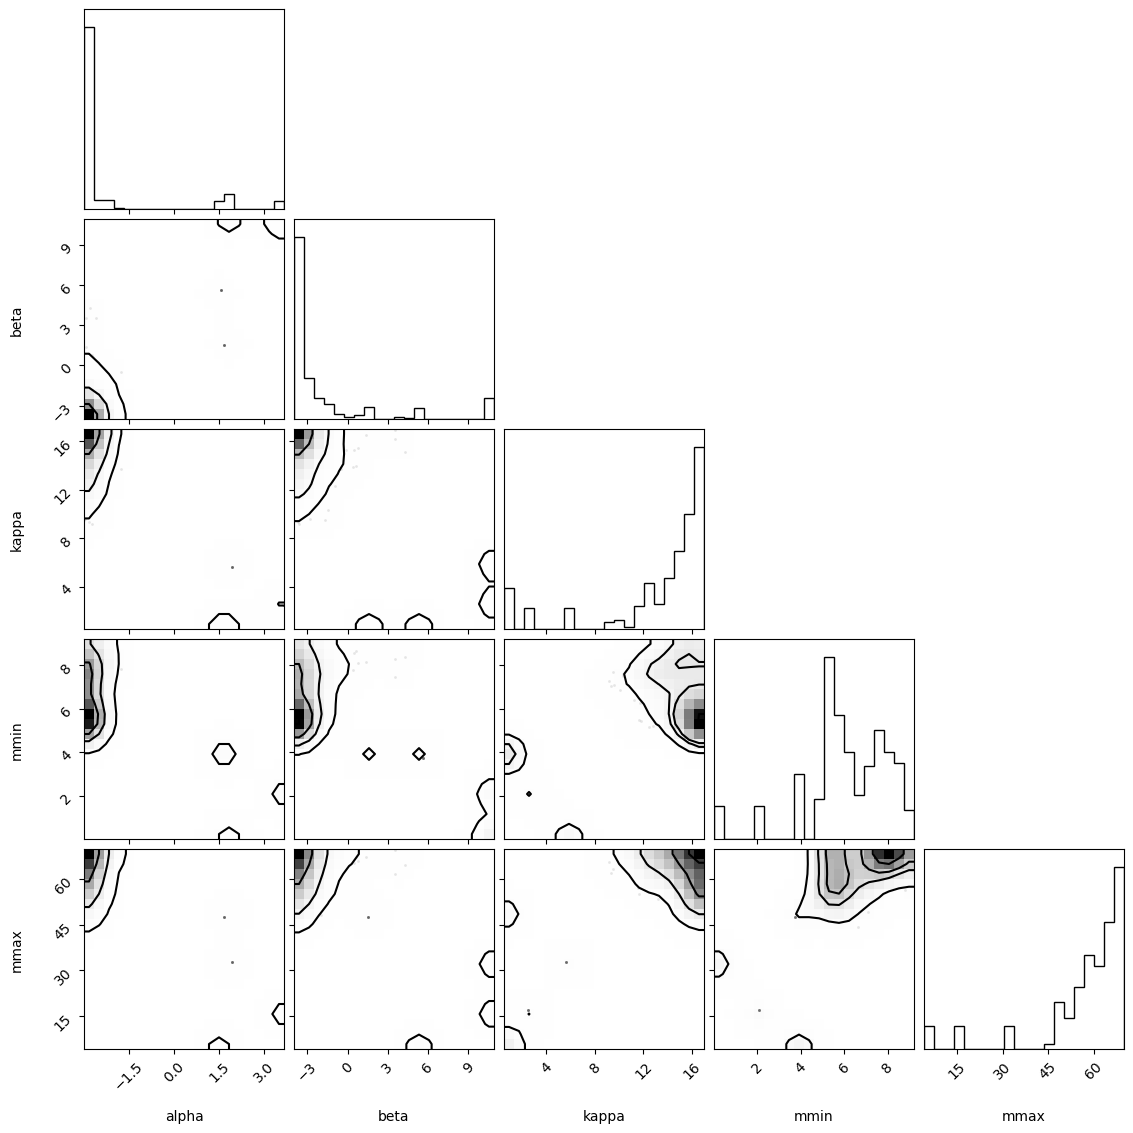

In [4]:
import corner

# labels = ['alpha', 'beta', 'mmin', 'mmax', 'lam', 'mpp', 'sigpp']
labels = ['alpha', 'beta', 'kappa', 'mmin', 'mmax']

fig = corner.corner(
    flat_samples, labels=labels, smooth=1.2
);

In [21]:
np.random.uniform(fast_priors['alpha'].minimum, high=fast_priors['alpha'].maximum, size=30)

array([-0.46850964,  3.53805901,  3.46260344, -2.73128682, -1.52102049,
        3.14424101,  3.7988023 ,  2.35039026,  1.09620001, -2.81033524,
        3.62171618, -2.52852855,  3.88940953,  2.45132496,  1.37828029,
       -2.52122171,  3.80167024, -0.86690848, -0.87893204,  2.05051872,
        2.12008349, -2.71815943, -0.82232247, -2.80075871, -0.85751898,
        3.47106372, -2.91125092,  1.73978958, -0.42386431, -2.90172105])